# Task Two -- Named Entity Recognition (BioNLP)

## Importing Packages

In [57]:
# !pip install python-crfsuite
# !pip install --upgrade nltk

     ---------------------------------------- 2.1/2.1 MB 14.6 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\misha\anaconda3\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset # Doesn't work on my PyCharm
import nltk
import pycrfsuite

## Importing the Dataset

In [9]:
# Define the directory
cache_dir = "./data_cache"

# Load the training set
train_dataset = load_dataset("tner/bionlp2004", split="train", cache_dir=cache_dir)
print(f"Training dataset with {len(train_dataset)} instances.")

# Load the testing set
test_dataset = load_dataset("tner/bionlp2004", split="test", cache_dir=cache_dir)
print(f"Training dataset with {len(test_dataset)} instances.")

Found cached dataset bionlp2004 (C:/Users/misha/Documents/University/MSc FinTech with Data Science/Semester Two/INDA/Coursework/INDA-NLP-Coursework/data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


Training dataset with 16619 instances.


Found cached dataset bionlp2004 (C:/Users/misha/Documents/University/MSc FinTech with Data Science/Semester Two/INDA/Coursework/INDA-NLP-Coursework/data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


Training dataset with 3856 instances.


In [10]:
print(f"One training instance: \n\n{train_dataset[234]}\n")
print(f"And its labels: \n\n{train_dataset[234]}")

One training instance: 

{'tokens': ['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.'], 'tags': [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 4, 0]}

And its labels: 

{'tokens': ['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.'], 'tags': [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 4, 0]}


In [11]:
# Mapping from labels to the tags
id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

# Swapping key, value around to map tags to labels
ner_tag_mapping = {v:k for k, v in id2label.items()}
print(ner_tag_mapping)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}


In [12]:
train_set = [list(zip(s["tokens"], [ner_tag_mapping[tok] for tok in s["tags"]])) for s in train_dataset][:-1]
test_set = [list(zip(s["tokens"], [ner_tag_mapping[tok] for tok in s["tags"]])) for s in test_dataset][:-1]
test_tokens = [s["tokens"] for s in test_dataset][:-1]
test_tags = [[ner_tag_mapping[tok] for tok in s["tags"]] for s in test_dataset][:-1]

## Training the Conditional Random Field (CRF) Tagger

In [38]:
def train_CRF_NER_tagger(train_set):
    tagger = nltk.tag.CRFTagger()
    tagger.train(train_set, "model.crf.tagger")
    return tagger

tagger = train_CRF_NER_tagger(train_set)

In [39]:
predicted_tags = tagger.tag_sents(test_tokens)

In [40]:
def extract_spans(tagged_sents):
    """
    Extract a list of tagged spans for each named entity type, 
    where each span is represented by a tuple containing the 
    start token and end token indexes.
    
    returns: a dictionary containing a list of spans for each entity type.
    """
    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1      
        # Sometimes an I-token is the last token in the sentence, so we still have to add the span to the list
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))
                
    return spans


def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'Micro-Average F1 score for {ne_type} = {f1}')
        
    macro_f1 = np.mean(f1_per_class)
    print(f'Macro-average F1 score = {macro_f1}')
    f1_per_class.append(macro_f1)
    return(f1_per_class)

default_crf_metrics = cal_span_level_f1(test_set, predicted_tags)

Micro-Average F1 score for protein = 0.6528846153846154
Micro-Average F1 score for cell_type = 0.6316096990943617
Micro-Average F1 score for DNA = 0.5853413654618472
Micro-Average F1 score for cell_line = 0.48218029350104824
Micro-Average F1 score for RNA = 0.6017699115044248
Macro-average F1 score = 0.5907571769892594


In [41]:
import re, unicodedata

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, idx):
            """
            Extract basic features about this word including
                - Current word
                - is it capitalized?
                - Does it have punctuation?
                - Does it have a number?
                - Suffixes up to length 3
            """
            token = tokens[idx]

            feature_list = []

            if not token:
                return feature_list

            # Capitalization
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")

            # Number
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # Suffix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

                
            # Current word
            feature_list.append("WORD_" + token)
            if idx > 0:
                feature_list.append("PREVWORD_" + tokens[idx-1])
            if idx < len(tokens)-1:
                feature_list.append("NEXTWORD_" + tokens[idx+1])

            return feature_list

In [42]:
# Train a CRF NER tagger
def train_CustomCRF_NER_tagger(train_set):
    ### WRITE YOUR OWN CODE HERE
    tagger = CustomCRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger  # return the trained model

tagger = train_CustomCRF_NER_tagger(train_set)

In [43]:
predicted_tags = tagger.tag_sents(test_tokens)
custom_crf_metrics = cal_span_level_f1(test_set, predicted_tags)

Micro-Average F1 score for protein = 0.6889548807357027
Micro-Average F1 score for cell_type = 0.7054376272172144
Micro-Average F1 score for DNA = 0.6479156202913108
Micro-Average F1 score for cell_line = 0.5298281092012133
Micro-Average F1 score for RNA = 0.6180257510729614
Macro-average F1 score = 0.6380323977036805


In [44]:
# *** Improve the CRF NER tagger using parts of speech (see lab 5) as additional features.
class CRFTaggerWithPOS(CustomCRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, index):
        """
        Extract the features for a token and append the POS tag as an additional feature.
        """
        basic_features = super()._get_features(tokens, index)
        
        # Get the pos tags for the current sentence and save it
        if tokens != self._current_tokens:
            self._pos_tagged_tokens = nltk.pos_tag(tokens)
            self._current_tokens = tokens
            
            
        ### WRITE YOUR OWN CODE HERE
        basic_features.append(self._pos_tagged_tokens[index][1])
        ###
        
        return basic_features

In [45]:
# Train a CRF NER tagger
def train_CRF_NER_tagger_with_POS(train_set):
    ### WRITE YOUR OWN CODE HERE
    tagger = CRFTaggerWithPOS()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger  # return the trained model

tagger = train_CRF_NER_tagger_with_POS(train_set)

In [46]:
predicted_tags = tagger.tag_sents(test_tokens)
pos_crf_metrics = cal_span_level_f1(test_set, predicted_tags)

Micro-Average F1 score for protein = 0.6908607258217746
Micro-Average F1 score for cell_type = 0.7069416206796398
Micro-Average F1 score for DNA = 0.6410767696909272
Micro-Average F1 score for cell_line = 0.5419615773508595
Micro-Average F1 score for RNA = 0.6233766233766234
Macro-average F1 score = 0.6408434633839649


## Visual Comparison

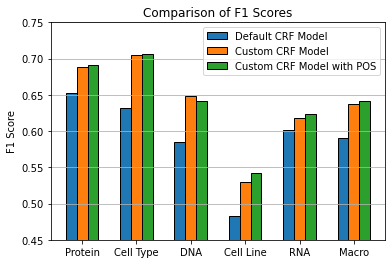

In [66]:
# define the different metrics and their scores for bayes with lem
metrics = ["Protein", "Cell Type", "DNA", "Cell Line", "RNA", "Macro"]

# set the width of the bars
bar_width = 0.20

# set the x-positions of the bars
r1 = np.arange(len(metrics)) + bar_width
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# create the bar plot
plt.bar(r1, default_crf_metrics, color="tab:blue", width=bar_width, edgecolor="black", label="Default CRF Model")
plt.bar(r2, custom_crf_metrics, color="tab:orange", width=bar_width, edgecolor="black", label="Custom CRF Model")
plt.bar(r3, pos_crf_metrics, color="tab:green", width=bar_width, edgecolor="black", label="Custom CRF Model with POS")


# add labels and title
plt.ylabel("F1 Score")
plt.xticks([r + bar_width*2 for r in range(len(metrics))], metrics)
plt.title("Comparison of F1 Scores")

# set y-axis limits
plt.ylim(0.45, 0.75)

# add legend
plt.legend()

# show the plot
plt.grid(axis="y")
plt.savefig("class_comparison.png", dpi=300)
plt.show()